# Top-level imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

The tensorboard module is not an IPython extension.


#### import packages - setup

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn import metrics
import datetime
import tensorflow as tf

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/tensorflow/pyth

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
data_dir = '../data/'

In [5]:
data_files = os.listdir(data_dir)
data_files.sort()
data_files

['BroughtonSeaLice_fishData.csv',
 'BroughtonSeaLice_fishInfo.csv',
 'BroughtonSeaLice_siteData.csv',
 'BroughtonSeaLice_siteInfo.csv',
 'DFOSeaLice_Data.csv',
 'DFOSeaLice_Info.csv',
 'IndustrySeaLice_Data.csv',
 'IndustrySeaLice_Info.csv',
 'README.md']

#### Wild data

In [6]:
fish_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishData.csv', encoding='ISO-8859-1')
site_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteData.csv', encoding='ISO-8859-1')

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
fish_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishInfo.csv', encoding='ISO-8859-1')
site_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteInfo.csv', encoding='ISO-8859-1')

#### Farm data

In [8]:
dfo_data = pd.read_csv(f'{data_dir}DFOSeaLice_Data.csv')
dfo_info = pd.read_csv(f'{data_dir}DFOSeaLice_Info.csv')

In [9]:
industry_data = pd.read_csv(f'{data_dir}IndustrySeaLice_Data.csv', encoding='ISO-8859-1', low_memory=False)
industry_info = pd.read_csv(f'{data_dir}IndustrySeaLice_Info.csv', encoding='ISO-8859-1', low_memory=False)

##### Data/Feature Engineering

Possible input scenarios
- 2001-2018: We have to trust that the model can work with the large amounts of NaN values in earlier years, both in wild data and no farmed data until 2011 
- 2003-2018: 2003 is the first year we have data starting in March


## Setting overall constants

Things to set here 
- Years to analyse
- Within-season date range
- Accepted ranges
- Resampling dates

In [10]:
analysis_years = list(range(2003, 2018))

In [11]:
analysis_months = list(range(3, 7))

In [12]:
dow_dict = {
    1: 'MON',
    2: 'TUE',
    3: 'WED',
    4: 'THU', 
    5: 'FRI', 
    6: 'SAT', 
    7: 'SUN'
}

def get_dow(dt_obj):
    dow_text = dt_obj.isoweekday()
    return(dow_dict[dow_text])

In [13]:
wild_locations = site_data['location'].unique()

## Setting up response

### Unified adult count
This is one possible response

In [14]:
adult = fish_data[['Lep_PAmale', 'Lep_PAfemale', 
                   'Lep_male', 'Lep_gravid',
                   'Lep_nongravid', 'unid_PA',
                   'unid_adult']].sum(axis=1)

In [15]:
fish_data_date = pd.to_datetime(fish_data[['year', 'day', 'month']])

In [16]:
response = pd.DataFrame({'count':adult.values, 
                         'location':fish_data['location'].values,
                         'datetime': fish_data_date})

In [17]:
response_glacier = response[response['location'] == 'Glacier']

In [18]:
year_df_list = []
for year in analysis_years:
    subset = response_glacier[response_glacier['datetime'].dt.year == year]
    subset.loc[0] = np.nan
    subset.loc[0, 'datetime'] = datetime.datetime(year, 1, 1)
    subset.loc[1] = np.nan
    subset.loc[1, 'datetime'] = datetime.datetime(year, 12, 31)
    subset.sort_values('datetime', inplace=True)
    subset_resampled = subset.resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                       on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_df_list.append(subset_resampled)
Y_glacier = pd.concat(year_df_list)

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [19]:
Y_glacier

,count
datetime,
2002-12-25,NaN
2003-01-01,NaN
2003-01-08,NaN
2003-01-15,NaN
2003-01-22,NaN
...,...
2017-11-26,0.0
2017-12-03,0.0
2017-12-10,0.0


resample by week for average

This is the code I was formerly using for the resampling, it's pretty inconsistent

Y_glacier = response_glacier.resample('W', on='datetime', label='left').apply(np.nanmean)

## Setting up inputs - wild data

## Setting up inputs - wild data

In [20]:
# non-motile lice
juvenile = pd.DataFrame(fish_data[['Lep_cope', 'chalA',
                      'chalB', 'Caligus_cope',
                      'unid_cope', 'chal_unid']].sum(axis=1)).rename({0: 'count'}, axis=1)
juvenile['datetime'] = fish_data_date
juvenile['location'] = fish_data['location']

In [21]:
year_juv_list = []
for year in analysis_years:
    subset = juvenile[juvenile['datetime'].dt.year == year]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'count': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_juv_list.append(subset_resample)
X_wild_juv = pd.concat(year_juv_list)

This is the code I was previously using to resample the juvenile counts, now outdated

X_wild_juv = juvenile.groupby('location').resample('W', on='datetime', label='left').apply(np.nanmean)

Reducing dimensionality - averaging is probably okay

In [22]:
site_data['datetime'] = pd.to_datetime(site_data[['year', 'month', 'day']])

In [23]:
year_temp_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'temp', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'temp': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_temp_list.append(subset_resample)
X_wild_temp = pd.concat(year_temp_list)

This is how I used to get these inputs, now outdated

X_wild_temp = site_data[['datetime', 'temp', 'location']]
X_wild_temp = X_wild_temp.groupby('location').resample('w', on='datetime', label='left').apply(np.nanmean)

In [24]:
year_sal_list = []
for year in analysis_years:
    subset = site_data.loc[(site_data['datetime'].dt.year == year), ['datetime', 'salt', 'location']]
    for loc in wild_locations:
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'location': loc,
            'salt': np.nan
        }, ignore_index=True)
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('location').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                          on='datetime', label='left').apply(np.nanmean).interpolate(method='linear')
    year_sal_list.append(subset_resample)
X_wild_sal = pd.concat(year_sal_list)

How I used to get these inputs, now outdated

X_wild_sal = site_data[['datetime', 'salt', 'location']]
X_wild_sal = X_wild_sal.groupby('location').resample('w', on='datetime', label='left').apply(np.nanmean)

## Setting up inputs - farm data

- There are of course concerns with using the industry counts as they *may* be of very low quality (I need to look much more extensively into this data)
    - Should look into what kind of predictive differences including/excluding these has 

Inputs that we want

44 - Sargeunts Pass

41 - Doctor Islet

45 - Humphrey Rock

56 - Glacier Falls

54 - Simoom Sound

50 - Burdwood Islands

53 - Sir Edmond Bay

49 - Wicklow Point 

In [25]:
industry_data[industry_data['Site Common Name'].str.contains('Sir')]['Site Common Name'].unique()
# Can't find Simoom Sound??

array(['Sir Edmund Bay'], dtype=object)

To reduce dimensionality:

Sum farm data, implementing # of fish for some sort of area infection indicator

In [26]:
relevant_farms = ['Sargeaunt Pass',
                  'Doctor Islets',
                  'Humphrey Rock',
                  'Simoom Sound*',
                  'Burdwood',
                  'Glacier Falls',
                  'Sir Edmund Bay',
                  'Wicklow Point'
                 ]
relevant_farms_iterable = ['Sargeaunt Pass',
                           'Doctor Islets',
                           'Humphrey Rock',
                           'Burdwood',
                           'Glacier Falls',
                           'Sir Edmund Bay',
                           'Wicklow Point'
                          ]


In [27]:
industry_data[industry_data['Site Common Name'].str.contains('|'.join(relevant_farms))]['Site Common Name'].unique()

array(['Burdwood', 'Sir Edmund Bay', 'Doctor Islets', 'Glacier Falls',
       'Wicklow Point', 'Sargeaunt Pass', 'Humphrey Rock',
       'Wicklow Point - post treatment', 'Wicklow Point - pre treatment',
       'Wicklow Point - post-treatment', 'Wicklow Point - pre-treatment'],
      dtype=object)

From what I can tell - most of these farms don't actually have a treatment indicator

Wondering if this is significant? 

I also can't find Simoom Sound, maybe it's here under a different name? 

In [28]:
comments_examples = industry_data[industry_data['Site Common Name'] == 'Burdwood']['Comments'].unique()

This is how I was resampling the industry data before

X_industry = relevant_farm_data[['datetime',
                            'Site Common Name',
                            'Average L. salmonis motiles per fish',
                            'Average chalimus per fish']]
X_industry = X_industry.groupby('Site Common Name').resample('W', on='datetime', label='left').mean()

The "Recent failure to control sea louse..." paper should have all the data I need until 2015

In [29]:
relevant_farm_data = industry_data[industry_data['Site Common Name'].str.contains('|'.join(relevant_farms))]

relevant_farm_data['Day'] = 1
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
relevant_farm_data['month'] = relevant_farm_data['Month'].map(month_map)
relevant_farm_data['datetime'] = pd.to_datetime(relevant_farm_data[['Year', 'month', 'Day']])

relevant_farm_data = relevant_farm_data[relevant_farm_data['datetime'].dt.year.isin(analysis_years)]

year_industry_list = []
for year in analysis_years:
    subset = relevant_farm_data.loc[(relevant_farm_data['datetime'].dt.year == year), 
                                   ['datetime', 'Site Common Name', 'Average L. salmonis motiles per fish']]
    
    for i, farm in enumerate(relevant_farms_iterable):
        subset = subset.append({
            'datetime': datetime.datetime(year, 1 , 1),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
        subset = subset.append({
            'datetime': datetime.datetime(year, 12 , 31),
            'Site Common Name': farm,
            'Average L. salmonis motiles per fish': np.nan
        }, ignore_index=True)
            
    subset.sort_values('datetime', inplace=True)
    subset_resample = subset.groupby('Site Common Name').resample(f'W-{get_dow(datetime.datetime(year, 1, 1))}',
                                                                 on='datetime', label='left').apply(np.nanmean).interpolate(methods='linear')
    year_industry_list.append(subset_resample)
X_industry = pd.concat(year_industry_list)


/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

### Forming array for model input

In [30]:
arrays_to_stack = []

for year in analysis_years:
    juv_sub = np.nanmean(X_wild_juv[(X_wild_juv.index.get_level_values(1).year == year) & 
                         X_wild_juv.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    temp_sub = np.nanmean(X_wild_temp[(X_wild_temp.index.get_level_values(1).year == year) & 
                           X_wild_temp.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    sal_sub = np.nanmean(X_wild_sal[(X_wild_sal.index.get_level_values(1).year == year) & 
                         X_wild_sal.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    ind_sub = np.nanmean(X_industry[(X_industry.index.get_level_values(1).year == year) & 
                         X_industry.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values, axis=1)
    
    year_array = np.column_stack((juv_sub, temp_sub, sal_sub, ind_sub))
    arrays_to_stack.append(year_array)
    
X = np.stack(arrays_to_stack, axis=0)

/opt/anaconda3/envs/EEB498/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [31]:
X.shape

(15, 17, 4)

In [62]:
arrays_to_stack = []

for year in analysis_years:
    year_Y = Y_glacier[(Y_glacier.index.year == year) & 
                       Y_glacier.index.month.isin(analysis_months)].values
    arrays_to_stack.append(year_Y)
    
Y = np.stack(arrays_to_stack, axis=0)

In [33]:
Y.shape

(15, 17, 1)

Saving the data to be sent to R, this is to ensure that I'm using the same data for both analyses

# Experimenting with models

## Import packages and set up functions

Write normalising functions here (let's go with MinMaxScaling for future implementations)

## Setup Data

### Normalise and fill NAs

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
X_scale = np.copy(X)
scalers_x = {}
for i in range(X.shape[1]):
    scalers_x[i] = MinMaxScaler(feature_range=(-1, 1))
    X_scale[:, i, :] = scalers_x[i].fit_transform(X[:, i, :])
X_scale = np.nan_to_num(X_scale)

Y_scale = np.copy(Y)
scalers_y = {}
for i in range(Y.shape[1]):
    scalers_y[i] = MinMaxScaler(feature_range=(-1, 1))
    Y_scale[:, i, :] = scalers_y[i].fit_transform(Y[:, i, :]) 
Y_scale = np.nan_to_num(Y_scale)

### Split into train and test

In [38]:
train_X = X_scale[:-3]
train_Y = Y_scale[:-3]

test_X = X_scale[-3:]
test_Y = Y_scale[-3:]

## Baseline

### Overall Avg

### Naive seasonal

In [39]:
def naive_seasonal(year: int, reference_data: pd.DataFrame):
    '''
    Naive seasonal model
    This model takes a year to be predicted in and returns the last known year's values
    
    year: Year to be predicted
    reference_data: Pandas dataframe of the test/input Y data, must have a DatetimeIndex index
    '''
    
    
    pred_subset = reference_data[reference_data.index.year == year]
    preds = pred_subset[pred_subset.index.month.isin(analysis_months)]
    
    return(np.array(preds))

### ARIMA

## Non-parametric

Some high level notes
- This analysis is very rough and is in no way final!!!
- The normalising, feature engineering, etc. is probably the roughest part of all of this. I don't expect it to have an effect on model choice but by no means should the input/output data be taken verbatim as what I intend to use
- Optimizers: some reading has shown that RMSprop is the suggested optimiser for RNNs, this also coincides with François Chollet's use of optimisers so for now I am going with this one for RNNs and ADAM as the default for all others. This requires further research!
- Reference points: 
     - ARIMA
     - Mean & SD

### Setting up tensorboard logs

### LSTM

Notes on LSTM

In [40]:
!rm -rf ./logs/ 
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [43]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(64))

model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.LSTM(32, input_shape=(17, 4),
               return_sequences=True,
               activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(32))

model.add(tf.keras.layers.Dropout(rate=0.2))

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', 
              loss='mse',
              metrics=['acc'])

history = model.fit(train_X, train_Y, 
                    epochs=500, batch_size=16,
                    validation_split=0.2,)
                    #callbacks=[tensorboard_callback])

Train on 9 samples, validate on 3 samples
Epoch 1/500
9/9 [==============================] - 2s 173ms/sample - loss: 0.7675 - acc: 0.1307 - val_loss: 0.6748 - val_acc: 0.2353
Epoch 2/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.7144 - acc: 0.1307 - val_loss: 0.6176 - val_acc: 0.2353
Epoch 3/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.6795 - acc: 0.1307 - val_loss: 0.5673 - val_acc: 0.2353
Epoch 4/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.6470 - acc: 0.1307 - val_loss: 0.5215 - val_acc: 0.2353
Epoch 5/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.6103 - acc: 0.1307 - val_loss: 0.4787 - val_acc: 0.2353
Epoch 6/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.5882 - acc: 0.1307 - val_loss: 0.4364 - val_acc: 0.2353
Epoch 7/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.5566 - acc: 0.1307 - val_loss: 0.3929 - val_acc: 0.2353
Epoch 8/500
9/9 [======================

Epoch 63/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.2175 - acc: 0.1699 - val_loss: 0.0821 - val_acc: 0.2353
Epoch 64/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.2211 - acc: 0.1765 - val_loss: 0.0822 - val_acc: 0.2353
Epoch 65/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.2162 - acc: 0.1895 - val_loss: 0.0829 - val_acc: 0.2353
Epoch 66/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.2069 - acc: 0.1699 - val_loss: 0.0842 - val_acc: 0.2353
Epoch 67/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1997 - acc: 0.1765 - val_loss: 0.0861 - val_acc: 0.2353
Epoch 68/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.2020 - acc: 0.1895 - val_loss: 0.0886 - val_acc: 0.2353
Epoch 69/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.2114 - acc: 0.1830 - val_loss: 0.0912 - val_acc: 0.2353
Epoch 70/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.

Epoch 125/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1731 - acc: 0.1895 - val_loss: 0.1142 - val_acc: 0.2353
Epoch 126/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1825 - acc: 0.1961 - val_loss: 0.1131 - val_acc: 0.2353
Epoch 127/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1781 - acc: 0.1895 - val_loss: 0.1141 - val_acc: 0.2353
Epoch 128/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1852 - acc: 0.1765 - val_loss: 0.1174 - val_acc: 0.2353
Epoch 129/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1756 - acc: 0.1961 - val_loss: 0.1232 - val_acc: 0.2353
Epoch 130/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1777 - acc: 0.1961 - val_loss: 0.1300 - val_acc: 0.2353
Epoch 131/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1761 - acc: 0.1830 - val_loss: 0.1370 - val_acc: 0.2353
Epoch 132/500
9/9 [==============================] - 0s 4ms/sample - 

Epoch 187/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1607 - acc: 0.1961 - val_loss: 0.1622 - val_acc: 0.2353
Epoch 188/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1400 - acc: 0.2026 - val_loss: 0.1642 - val_acc: 0.2353
Epoch 189/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1326 - acc: 0.2026 - val_loss: 0.1652 - val_acc: 0.2353
Epoch 190/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1449 - acc: 0.1895 - val_loss: 0.1636 - val_acc: 0.2353
Epoch 191/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1603 - acc: 0.1830 - val_loss: 0.1536 - val_acc: 0.2353
Epoch 192/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1456 - acc: 0.1961 - val_loss: 0.1466 - val_acc: 0.2353
Epoch 193/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1441 - acc: 0.1830 - val_loss: 0.1431 - val_acc: 0.2353
Epoch 194/500
9/9 [==============================] - 0s 3ms/sample - 

Epoch 249/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1186 - acc: 0.1961 - val_loss: 0.1845 - val_acc: 0.2353
Epoch 250/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1227 - acc: 0.1699 - val_loss: 0.1916 - val_acc: 0.2353
Epoch 251/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1140 - acc: 0.2026 - val_loss: 0.2000 - val_acc: 0.2353
Epoch 252/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1260 - acc: 0.1895 - val_loss: 0.2046 - val_acc: 0.2353
Epoch 253/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1354 - acc: 0.1961 - val_loss: 0.2021 - val_acc: 0.2353
Epoch 254/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1182 - acc: 0.2026 - val_loss: 0.1962 - val_acc: 0.2353
Epoch 255/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1094 - acc: 0.2092 - val_loss: 0.1927 - val_acc: 0.2353
Epoch 256/500
9/9 [==============================] - 0s 3ms/sample - 

Epoch 311/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1040 - acc: 0.2026 - val_loss: 0.2041 - val_acc: 0.2353
Epoch 312/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1148 - acc: 0.2026 - val_loss: 0.2161 - val_acc: 0.2353
Epoch 313/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1011 - acc: 0.2092 - val_loss: 0.2267 - val_acc: 0.2353
Epoch 314/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1109 - acc: 0.2092 - val_loss: 0.2236 - val_acc: 0.2353
Epoch 315/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.0987 - acc: 0.1895 - val_loss: 0.2197 - val_acc: 0.2353
Epoch 316/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1063 - acc: 0.1895 - val_loss: 0.2169 - val_acc: 0.2353
Epoch 317/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1169 - acc: 0.1961 - val_loss: 0.2183 - val_acc: 0.2353
Epoch 318/500
9/9 [==============================] - 0s 3ms/sample - 

Epoch 373/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0972 - acc: 0.2092 - val_loss: 0.2199 - val_acc: 0.2353
Epoch 374/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0903 - acc: 0.2092 - val_loss: 0.2156 - val_acc: 0.2353
Epoch 375/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1109 - acc: 0.1961 - val_loss: 0.2070 - val_acc: 0.2353
Epoch 376/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.1043 - acc: 0.1895 - val_loss: 0.1990 - val_acc: 0.2353
Epoch 377/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0966 - acc: 0.2092 - val_loss: 0.1935 - val_acc: 0.2353
Epoch 378/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.1046 - acc: 0.2092 - val_loss: 0.1889 - val_acc: 0.2353
Epoch 379/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0832 - acc: 0.2157 - val_loss: 0.1879 - val_acc: 0.2353
Epoch 380/500
9/9 [==============================] - 0s 4ms/sample - 

Epoch 435/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0776 - acc: 0.2092 - val_loss: 0.1516 - val_acc: 0.2353
Epoch 436/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.0874 - acc: 0.2157 - val_loss: 0.1478 - val_acc: 0.2353
Epoch 437/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0910 - acc: 0.1895 - val_loss: 0.1442 - val_acc: 0.2353
Epoch 438/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.0935 - acc: 0.1961 - val_loss: 0.1407 - val_acc: 0.2353
Epoch 439/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.0887 - acc: 0.1961 - val_loss: 0.1388 - val_acc: 0.2353
Epoch 440/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.0895 - acc: 0.1961 - val_loss: 0.1386 - val_acc: 0.2353
Epoch 441/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.0914 - acc: 0.2026 - val_loss: 0.1395 - val_acc: 0.2353
Epoch 442/500
9/9 [==============================] - 0s 4ms/sample - 

Epoch 497/500
9/9 [==============================] - 0s 3ms/sample - loss: 0.0787 - acc: 0.2092 - val_loss: 0.1364 - val_acc: 0.2353
Epoch 498/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0900 - acc: 0.2026 - val_loss: 0.1327 - val_acc: 0.2353
Epoch 499/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0705 - acc: 0.2092 - val_loss: 0.1295 - val_acc: 0.2353
Epoch 500/500
9/9 [==============================] - 0s 4ms/sample - loss: 0.0801 - acc: 0.2157 - val_loss: 0.1255 - val_acc: 0.2353


In [42]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [44]:
train_predictions = model.predict(train_X)

# Train RMSE
metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                           train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))

0.06931084512304374

In [45]:
test_predictions = model.predict(test_X)

# Test RMSE
metrics.mean_squared_error(test_Y.reshape(test_Y.shape[0], test_Y.shape[1] * test_Y.shape[2]),
                           test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))

0.3719095387381358

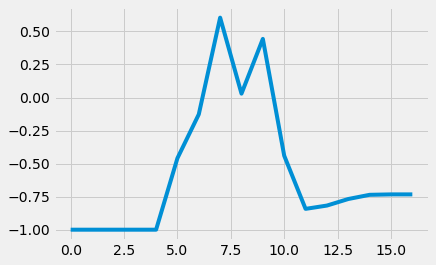

In [54]:
plt.plot(train_Y[2])

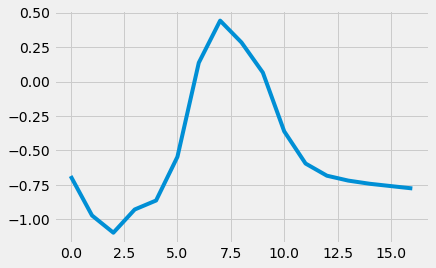

In [55]:
plt.plot(train_predictions[2])

## Parametric

### ARIMA